In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

import os 
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf

# Data
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.layers import concatenate
from keras.layers import Multiply
from keras.layers import Input


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Add

from keras.preprocessing.image import load_img, img_to_array

# Metrics
from keras.metrics import MeanIoU

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM


In [5]:
def load_image(image, SIZE):
    image = tf.cast(tfi.resize(img_to_array(load_img(image)), (SIZE, SIZE)), tf.float32)/255.
    return image

def load_images(paths, SIZE, trim=None, channels=3):
  
    if trim is not None:
        paths = paths[:trim]
        images = np.zeros(shape=(len(paths), SIZE, SIZE, channels))

    if channels==3:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img
    elif channels==1:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img[:,:,:1]
    return images

def show_image(image, title=None, cmap=None, alpha=1.0):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None: plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap='jet', alpha=0.2):
    show_image(image)
    show_image(tf.squeeze(mask), cmap=cmap, alpha=alpha)


In [6]:
root_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/'
image_path = root_path + 'images/'
mask_path = root_path + 'masks/'

image_paths = sorted(glob(image_path + '*.png'))
mask_paths = []
for path in image_paths:
    mask_paths.append(path.replace('images','masks'))
    
images = load_images(image_paths, SIZE=256, trim=200)
masks = load_images(mask_paths, SIZE=256, trim=200, channels=1)


2022-10-27 20:01:17.330506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 20:01:17.331504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 20:01:17.680518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 20:01:17.681417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 20:01:17.682260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

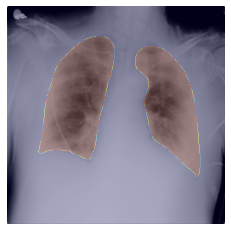

In [7]:
show_mask(images[0], masks[0], alpha=0.2)

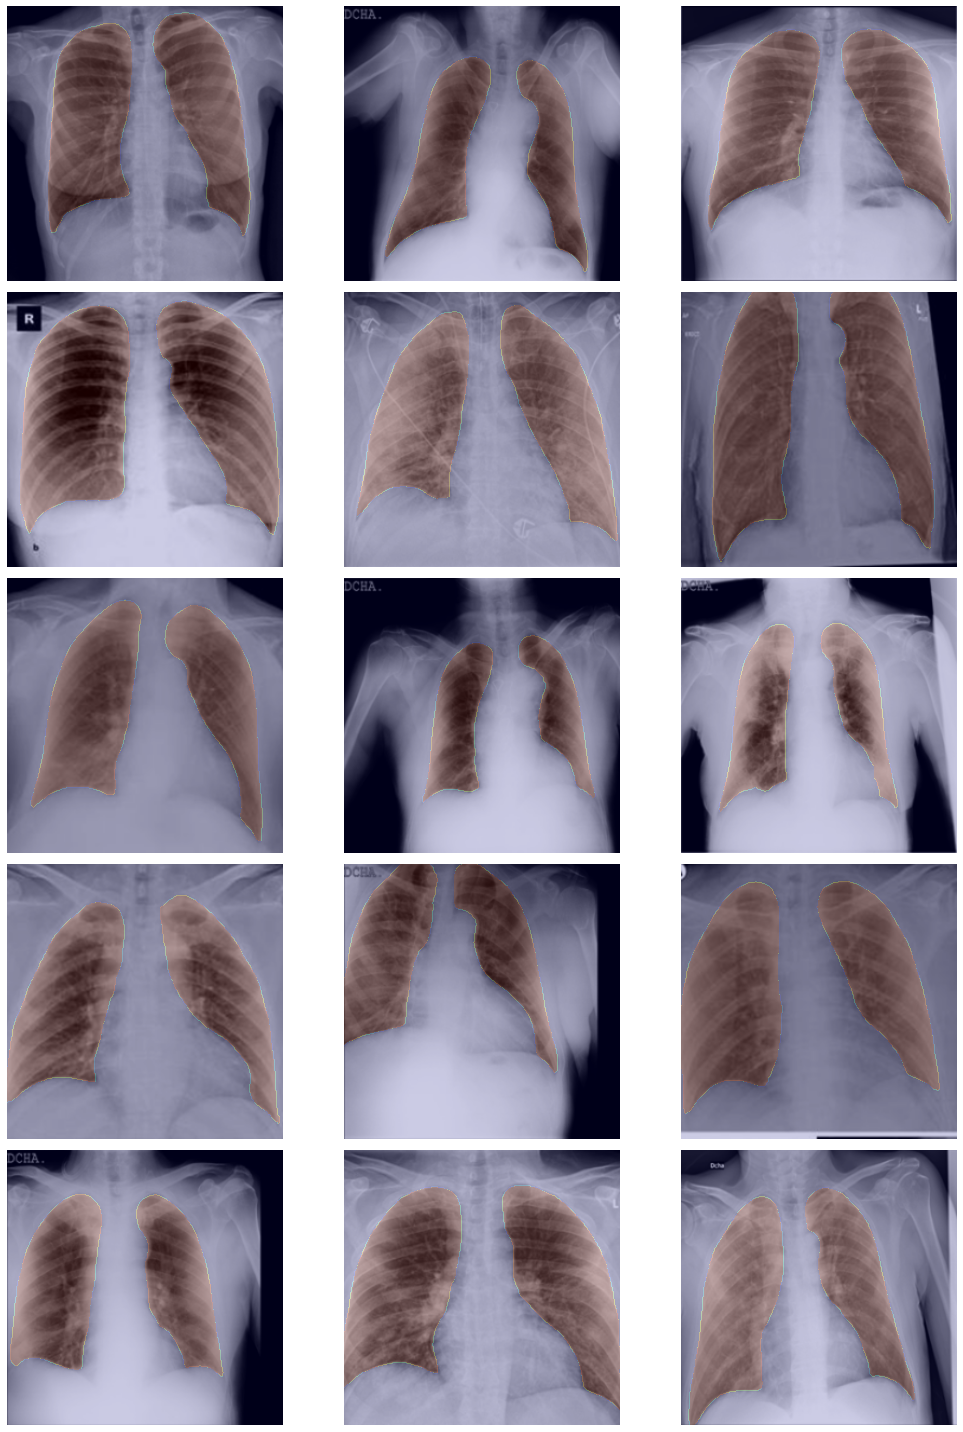

In [8]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id])
plt.tight_layout()
plt.show()

In [9]:
SIZE = 256
images, masks = load_images(image_paths, SIZE, trim=2000), load_images(mask_paths, SIZE, trim=2000, channels=1)

In [10]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [11]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1),padding='same', activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',MeanIoU(2)])
model.summary()

################################

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer
        ]

2022-10-27 20:02:05.530611: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-27 20:02:05.530648: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-27 20:02:05.534603: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-10-27 20:02:06.022634: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-27 20:02:06.022833: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [13]:
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

In [14]:
results = model.fit(images, masks,
    validation_split=0.1,
    epochs=25, # This is more than sufficient
    steps_per_epoch=SPE, batch_size=16, callbacks=callbacks)


2022-10-27 20:02:06.701890: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1415577600 exceeds 10% of free system memory.
2022-10-27 20:02:09.024299: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1415577600 exceeds 10% of free system memory.
2022-10-27 20:02:10.665063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-10-27 20:02:14.454563: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/250 [..............................] - ETA: 1:13:07 - loss: 0.6954 - accuracy: 0.2375 - mean_io_u: 0.3816

2022-10-27 20:02:28.455684: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-27 20:02:28.455736: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/250 [..............................] - ETA: 5:00 - loss: 0.6939 - accuracy: 0.4954 - mean_io_u: 0.3791   

2022-10-27 20:02:29.590068: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-27 20:02:29.591165: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-27 20:02:29.753208: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 598 callback api events and 594 activity events. 
2022-10-27 20:02:29.777245: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-27 20:02:29.826042: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_27_20_02_29

2022-10-27 20:02:29.841955: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_10_27_20_02_29/aa5400eb4868.trace.json.gz
2022-10-27 20:02:29.897816: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

250/250 [==============================] - 56s 155ms/step - loss: 0.3377 - accuracy: 0.8410 - mean_io_u: 0.3763 - val_loss: 0.1452 - val_accuracy: 0.9520 - val_mean_io_u: 0.3875

Epoch 00001: val_loss improved from inf to 0.14519, saving model to model_for_nuclei.h5
Epoch 2/25
250/250 [==============================] - 36s 143ms/step - loss: 0.1372 - accuracy: 0.9464 - mean_io_u: 0.3770 - val_loss: 0.1009 - val_accuracy: 0.9610 - val_mean_io_u: 0.3875

Epoch 00002: val_loss improved from 0.14519 to 0.10094, saving model to model_for_nuclei.h5
Epoch 3/25
250/250 [==============================] - 37s 148ms/step - loss: 0.1066 - accuracy: 0.9586 - mean_io_u: 0.3820 - val_loss: 0.0854 - val_accuracy: 0.9708 - val_mean_io_u: 0.3875

Epoch 00003: val_loss improved from 0.10094 to 0.08539, saving model to model_for_nuclei.h5
Epoch 4/25
250/250 [==============================] - 37s 149ms/step - loss: 0.0855 - accuracy: 0.9665 - mean_io_u: 0.3885 - val_loss: 0.0610 - val_accuracy: 0.9748 - va

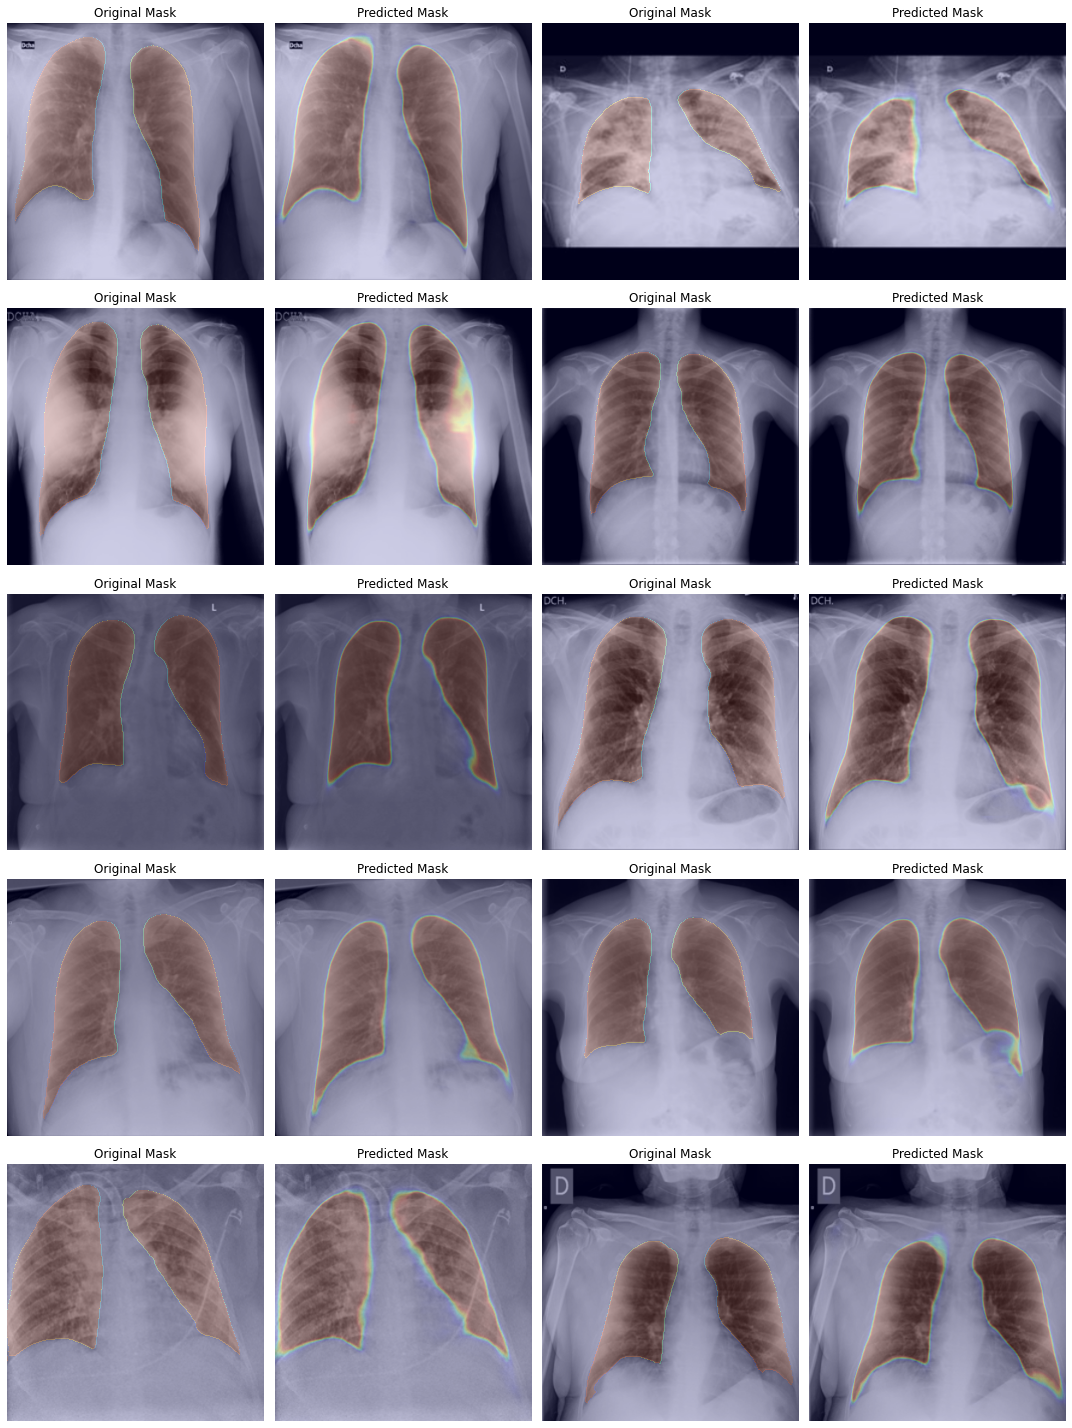

In [15]:
plt.figure(figsize=(15,20))
n = 0
for i in range(1,21):
    plt.subplot(5,4,i)

    if n==0:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        pred_mask = model.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==3:
        pred_mask = model.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

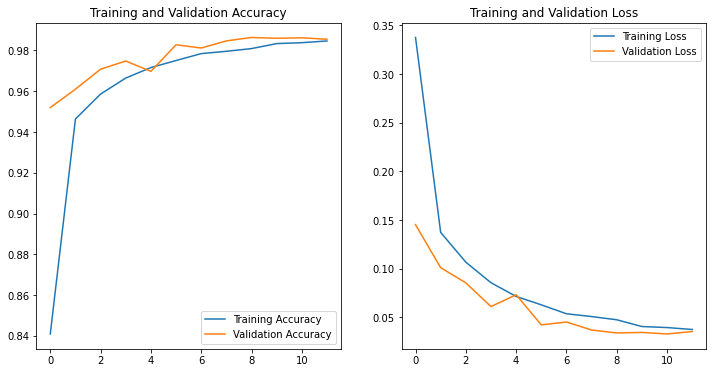

In [17]:
#showing results and model accuracy 
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']
#epochs=30
epochs_range = range(12)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()